In [4]:
import pandas as pd
from tqdm import tqdm
from multiprocessing import Pool
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import NaiveBayesClassifier
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report



nltk.download('punkt')  # Download the required data for tokenization
nltk.download('stopwords')  # Download the required data for stopwords
nltk.download('wordnet')  # Download the required data for lemmatization

[nltk_data] Downloading package punkt to /home/ucloud/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ucloud/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ucloud/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
#! pip install -r requirements.txt

In [6]:
pickle_path = './cleaned_df/df_cleaned_engl.pkl'
df = pd.read_pickle(pickle_path)
df.head()

,title,tag,artist,year,lyrics,id,language
0,Killa Cam,rap,Cam'ron,2004,"[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...",1,en
1,Can I Live,rap,JAY-Z,1996,"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...",3,en
2,Forgive Me Father,rap,Fabolous,2003,Maybe cause I'm eatin\nAnd these bastards fien...,4,en
3,Down and Out,rap,Cam'ron,2004,[Produced by Kanye West and Brian Miller]\n\n[...,5,en
4,Fly In,rap,Lil Wayne,2005,"[Intro]\nSo they ask me\n""Young boy\nWhat you ...",6,en


**Initial Filtering**

In [7]:
# drop nan values in columns lyrics, tag, and title
df.dropna(subset=['lyrics', 'tag', 'title'], inplace=True)

# Check for duplicates based on the combination of title' and artist
duplicates = df.duplicated(subset=['title', 'artist'], keep=False)
# Invert the boolean condition to keep rows that do not occur twice
df = df[~duplicates]

# Dropping the the title, artist, and language column in-place, since we're interested in the lyrics and tag primarily and year secondary
df.drop(['title', 'artist', 'language'], axis=1, inplace=True)

df.head()

,tag,year,lyrics,id
0,rap,2004,"[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...",1
1,rap,1996,"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...",3
2,rap,2003,Maybe cause I'm eatin\nAnd these bastards fien...,4
3,rap,2004,[Produced by Kanye West and Brian Miller]\n\n[...,5
4,rap,2005,"[Intro]\nSo they ask me\n""Young boy\nWhat you ...",6


In [8]:
df.shape

(4042571, 4)

**Time Filtering**

Considering changes in language over time, dropping songs before 1960 (arbitrary choice)

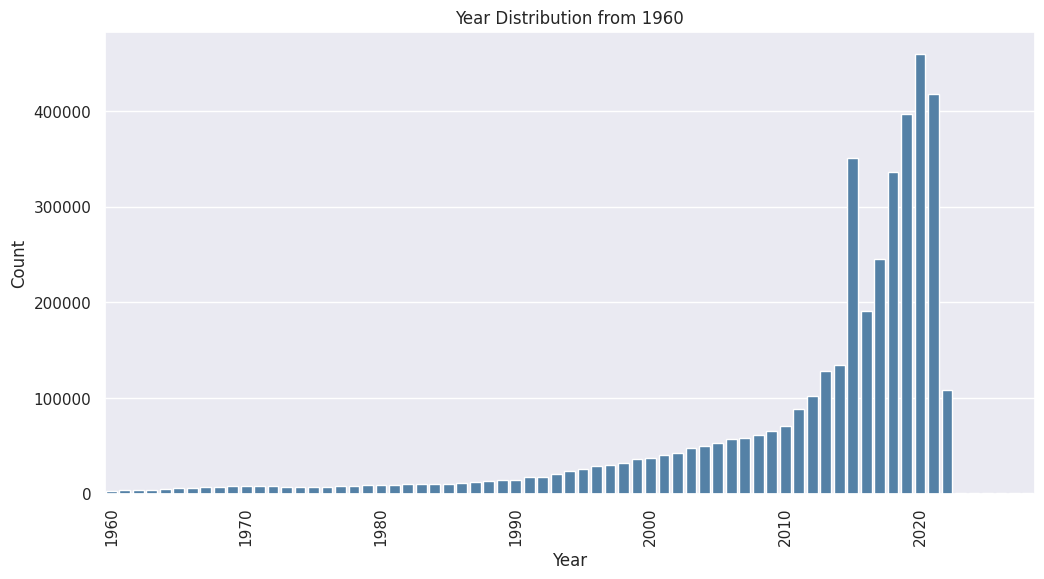

In [9]:

df = df[df['year'] >= 1960]

year_counts = df['year'].value_counts()
valid_years = year_counts.index

year_order = df['year'].sort_values().unique()
valid_years = valid_years[valid_years >= 1960]

valid_years = sorted(valid_years)  # Sort the valid years in ascending order


sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df[df['year'].isin(valid_years)], x='year', order=valid_years, color='steelblue')

# Display only every 10th year on the x-axis
every_10th_year = [year if i % 10 == 0 else '' for i, year in enumerate(valid_years)]
ax.set_xticklabels(every_10th_year)
plt.xticks(rotation=90)

plt.title('Year Distribution from 1960')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

In [10]:
df.shape

(4019912, 4)

**Word Processing**

In [11]:
# Examining word_count
df['word_count'] = df['lyrics'].apply(lambda x: len(x.split()))
df['word_count'].value_counts().describe()

count      3290.000000
mean       1221.857751
std       11055.504021
min           1.000000
25%           1.000000
50%           4.000000
75%         307.500000
max      620169.000000
Name: count, dtype: float64

Filter for less then 2500 words instead, since:

    1. Average song on Spotify is around three minutes (down from the peak in the 90's at 4min and 17 seconds)
    2. Someone found books etc in the dataset
    3. 2500 / 5 min = 500 words/min which is still a substantial safety margin
    4. Some songs are more than 

https://www.statista.com/chart/26546/mean-song-duration-of-currently-streamable-songs-by-year-of-release/

In [12]:
df = df[(df['word_count'] < 2500) & (df['word_count'] > 50)]
df.shape

(3252106, 5)

<Axes: xlabel='word_count', ylabel='Count'>

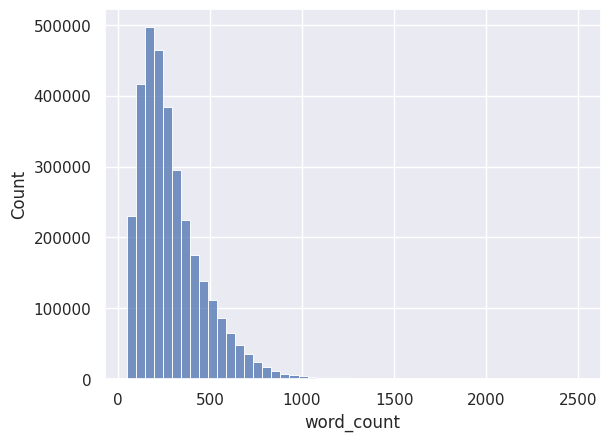

In [13]:
sns.histplot(data=df, x='word_count', bins=50)

In [14]:
# Save the DataFrame to a pickle file
df.to_pickle('./cleaned_df/df_eng_from_1960_wordcap_2500.pkl')
#df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Semester 2/NLP Exam Project/df_eng_from_1960_wordcap_2500.pkl')

In [15]:
df.loc[80, 'lyrics']

'[Produced by Kanye West and No I.D.]\n\n[Intro: Jay-Z]\nBlueprint, trois\nYeah, yeah\n\n[Verse 1: Jay-Z]\nWhat we talkin\' \'bout? Real shit or we talkin\' \'bout rhymes?\nYou talkin\' \'bout millions or you talkin\' \'bout mine?\nWhat we talkin\' \'bout? \'Cause I ain\'t got time\nFor what people be talkin\' \'bout all the time\nWhat we talkin\' \'bout? Fiction or we talkin\' \'bout fact?\nYou talkin\' \'bout fiction? Hold up, pardon my back\nI\'m talkin\' \'bout life (Life, life)\nAnd all I hear is, "Oh yeah, he keeps talkin\' \'bout crack"\nI ain\'t talkin\' \'bout profit, I\'m talkin\' \'bout pain\nI\'m talkin\' \'bout despair, I\'m talkin\' \'bout shame\nI ain\'t talkin\' \'bout gossip, I ain\'t talkin\' \'bout Game\nI ain\'t talkin\' \'bout Jimmy, I ain\'t talkin\' \'bout Dame\nI\'m talkin\' \'bout real shit, them people playin\'\nWhat is you talkin\' \'bout? I don\'t know what y\'all sayin\'\nPeople keep talkin\' \'bout, "Hov, take it back!"\nI\'m doin\' better than before, why

In [16]:
def strip_lyrics(lyrics):
    # Remove strings enclosed in brackets []
    lyrics = re.sub(r'\[.*?\]', '', lyrics)
    
    # Remove substrings starting with a backslash \
    lyrics = re.sub(r'\\[^\s]*', '', lyrics)

    # Remove newline characters \n
    lyrics = re.sub(r'\n', ' ', lyrics)
    
    # Remove single quotes '
    lyrics = re.sub(r"'", '', lyrics)
    
    # Remove punctuation and replace with space
    lyrics = re.sub(r'[{}]'.format(string.punctuation), ' ', lyrics)
    
    # Remove leading and trailing whitespaces
    lyrics = lyrics.strip()

    # Strip the string and ensure only one space between words
    lyrics = re.sub(r'\s+', ' ', lyrics.strip())

    # Tokenize
    tokens = word_tokenize(lyrics)
    
    # Lowercase tokens
    lowercase_tokens = [token.lower() for token in tokens]
    
    # Remove non-alphanumeric characters
    cleaned_tokens = [re.sub(r'[^a-zA-Z0-9]', '', token) for token in lowercase_tokens]
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    cleaned_tokens = [token for token in cleaned_tokens if token not in stop_words]
    
    # Lemmatize tokens
    #lemmatizer = WordNetLemmatizer()
    #cleaned_tokens = [lemmatizer.lemmatize(token) for token in cleaned_tokens]

    return cleaned_tokens

In [17]:
tqdm.pandas()
df['lyrics'] = df['lyrics'].progress_apply(lambda x: strip_lyrics(x))

100%|██████████| 3252106/3252106 [59:50<00:00, 905.82it/s]  


In [18]:
# Save the DataFrame to a pickle file
df.to_pickle('./cleaned_df/y1960_wc_2500_tokenized.pkl')
#df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Semester 2/NLP Exam Project/df_eng_from_1960_wordcap_2500.pkl')

In [38]:
df.drop(['year', 'id', 'word_count'], axis=1, inplace=True)
df.head()

,tag,lyrics
0,rap,"[killa, cam, killa, cam, cam, killa, cam, kill..."
1,rap,"[yeah, hah, yeah, roc, fella, invite, somethin..."
2,rap,"[maybe, cause, im, eatin, bastards, fiend, gru..."
3,rap,"[ugh, killa, baby, kanye, 1970s, heron, flow, ..."
4,rap,"[ask, young, boy, gon, second, time, around, g..."


In [26]:
!pip install imbalanced-learn


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 1.1 MB/s eta 0:00:0000:0100:01


In [39]:
from imblearn.under_sampling import RandomUnderSampler

# Separate the features and target variable
X = df.drop('tag', axis=1)  # Features
y = df['tag']  # Target variable

# Create an instance of RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)

# Undersample the data
X_undersampled, y_undersampled = undersampler.fit_resample(X, y)


In [40]:
X_undersampled

,lyrics
0,"[death, thy, sting, grave, thy, victory, life,..."
1,"[used, call, lightning, always, quick, strike,..."
2,"[college, working, part, time, waiting, tables..."
3,"[born, summer, 27th, year, comin, home, place,..."
4,"[shimmy, shimmy, go, go, motherfucking, pop, b..."
...,...
420025,"[na, nanana, na, nanana, na, na, na, na, na, n..."
420026,"[simlions, den, wei, oh, wei, oh, wei, oh, wei..."
420027,"[walking, distance, desert, without, end, hori..."
420028,"[rain, keeps, falling, tears, shed, ground, pl..."


In [41]:
# Convert 'X_undersampled' to a DataFrame
X_df = pd.DataFrame(X_undersampled, columns=X.columns)

# Convert 'y_undersampled' to a Series
y_series = pd.Series(y_undersampled, name='target')

# Concatenate 'X_df' and 'y_series'
merged_df = pd.concat([X_df, y_series], axis=1)

# Check the number of samples for each class
class_counts = merged_df['target'].value_counts()
print(class_counts)


target
country    84006
pop        84006
rap        84006
rb         84006
rock       84006
Name: count, dtype: int64


,lyrics,target
0,"[death, thy, sting, grave, thy, victory, life,...",country
1,"[used, call, lightning, always, quick, strike,...",country
2,"[college, working, part, time, waiting, tables...",country
3,"[born, summer, 27th, year, comin, home, place,...",country
4,"[shimmy, shimmy, go, go, motherfucking, pop, b...",country
...,...,...
420025,"[na, nanana, na, nanana, na, na, na, na, na, n...",rock
420026,"[simlions, den, wei, oh, wei, oh, wei, oh, wei...",rock
420027,"[walking, distance, desert, without, end, hori...",rock
420028,"[rain, keeps, falling, tears, shed, ground, pl...",rock


In [61]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(merged_df['lyrics'], merged_df['target'], test_size=0.2, random_state=42)

In [62]:
X_train

76728     [happens, every, night, havent, thought, one, ...
158809    [la, la, spoken, invade, culture, invade, citi...
342082    [go, head, clouds, feet, hole, wont, come, wor...
404913    [souvenir, visited, picturesque, unlimited, pr...
168980    [see, diamond, mirror, trying, brush, dirt, ni...
                                ...                        
259178    [pre, chorus, battle, dead, man, , switch, rig...
365838    [say, goodbye, dont, turn, back, , turn, aroun...
131932    [heres, something, think, would, without, nast...
146867    [talking, jesus, cloakroom, jesus, said, try, ...
121958    [oitsuzuketeta, yume, ga, hitoriaruki, ni, nat...
Name: lyrics, Length: 336024, dtype: object

In [ ]:
# Extract features for training
def extract_features(tokens):
    return {token: True for token in tokens}

In [63]:
# Create feature sets for training and testing
train_feature_sets = [(extract_features(tokens), label) for tokens, label in zip(X_train, y_train)]
test_feature_sets = [(extract_features(tokens), label) for tokens, label in zip(X_test, y_test)]

In [64]:
# Train the classifier
classifier = NaiveBayesClassifier.train(train_feature_sets)

In [66]:
# Make predictions on the test set
predictions = [classifier.classify(features) for features, _ in test_feature_sets]

# Evaluate the classifier
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

     country       0.72      0.05      0.10     16770
         pop       0.56      0.01      0.02     16808
         rap       0.21      1.00      0.34     16869
          rb       0.48      0.01      0.02     16618
        rock       0.77      0.03      0.06     16941

    accuracy                           0.22     84006
   macro avg       0.55      0.22      0.11     84006
weighted avg       0.55      0.22      0.11     84006



In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

# Extract the lyrics from the feature sets
X_train_lyrics = [' '.join(features.keys()) for features, _ in train_feature_sets]
X_test_lyrics = [' '.join(features.keys()) for features, _ in test_feature_sets]

# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the training feature sets
X_train_tfidf = vectorizer.fit_transform(X_train_lyrics)

# Transform the testing feature sets
X_test_tfidf = vectorizer.transform(X_test_lyrics)

# Extract the labels from the feature sets
y_train = [label for _, label in train_feature_sets]
y_test = [label for _, label in test_feature_sets]

# Create an instance of the SVM classifier
classifier = SVC()

# Train the SVM classifier
classifier.fit(X_train_tfidf, y_train)

# Evaluate the classifier
accuracy = classifier.score(X_test_tfidf, y_test)
